(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [15]:
import nltk
import math
import json
import nltk.sentiment.util as nsu
import nltk.sentiment.vader as nsv
from pprint import pprint

def halfRound(x):
    if(x > 4):
        return 5
    elif(x >= 3 and x < 3.5):
        return 3
    elif(x > 3.5 and x <= 4):
        return 4
    elif(x > 2 and x < 3):
        return 2
    elif(x < 2):
        return 1
    return x
    
def sentenceScore(sentence):
    analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='vader_lexicon.txt')
    s = analyzer.polarity_scores(sentence)
    neg = float(s['neg'])
    pos = float(s['pos'])
    score = 0
    if neg > pos:
        score = 5 - ((neg - pos) + 1) * 3
    elif neg == pos:
        return 3
    else:
        score = ((pos - neg) + 1) * 3
    return halfRound(score);

my_dict = {}
count = 0
match = 0
file_name="yelp_academic_dataset_review.json"
with open(file_name) as f:
    for line in f:
        count = count + 1
        js = json.loads(line)
        buff1 = int(sentenceScore(js["text"]))
        buff2 = int(js["stars"])
        if buff1 == buff2:
            match = match + 1
        if(count == 1000):
            break
print float(match)/float(count)
        


0.378


Just some testing code below of nltk package of python

In [ ]:
import nltk
import math
import json
import nltk.sentiment.util as nsu
import nltk.sentiment.vader as nsv
 
def halfRound(x):
    if x % 1 >= 0.5:
        return round(x) 
    else:
        return round(x - 0.5)
    
def sentenceScore(sentence):
    analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='vader_lexicon.txt')
    s = analyzer.polarity_scores(sentence)
    neg = float(s['neg'])
    pos = float(s['pos'])
    score = 0
    if neg > pos:
        score = 5 - ((neg - pos) + 1) * 3
    elif neg == pos:
        return 3
    else:
        score = ((pos - neg) + 1) * 3
    return halfRound(score)

sentence = "i have only had this camera for one full day and i have to say that it is wonderful"
print sentenceScore(sentence)


Visualization and short (detailed) analysis. **(10 pts)**

/Users/yili/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


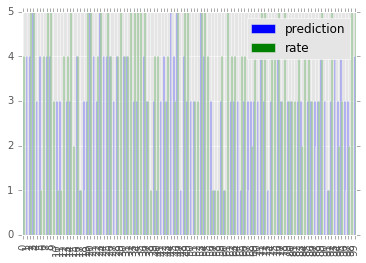

In [23]:
import pandas as pd
import nltk
import math
import json
import nltk.sentiment.util as nsu
import nltk.sentiment.vader as nsv
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

def halfRound(x):
    if(x > 4):
        return 5
    elif(x >= 3 and x < 3.5):
        return 3
    elif(x > 3.5 and x <= 4):
        return 4
    elif(x > 2 and x < 3):
        return 2
    elif(x < 2):
        return 1
    return x
    
def sentenceScore(sentence):
    analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='vader_lexicon.txt')
    s = analyzer.polarity_scores(sentence)
    neg = float(s['neg'])
    pos = float(s['pos'])
    score = 0
    if neg > pos:
        score = 5 - ((neg - pos) + 1) * 3
    elif neg == pos:
        return 3
    else:
        score = ((pos - neg) + 1) * 3
    return halfRound(score);
myList=[]
originList=[]
countList = []
count = 0
match = 0
file_name="yelp_academic_dataset_review.json"
with open(file_name) as f:
    for line in f:
        countList.append(count)
        js = json.loads(line)
        buff1 = int(sentenceScore(js["text"]))
        myList.append(buff1)
        buff2 = int(js["stars"])
        originList.append(buff2)
        count = count + 1
        if(count == 100):
            break
my_df = pd.DataFrame(myList)
origin_df = pd.DataFrame(originList)
plt.figure(figsize=(3,4))
result = pd.concat([my_df, origin_df], axis=1)
result.columns=['prediction', 'rate']
result.plot(kind='bar')


Analysis: The algorithm I am using is to compute the polarity of positive and negative words and convert the ratio between them to score in the range of 1 to 5. In most of the conditions, the difference between prediction and real rating is no larger than 2. So if it's a good restaurant, it could be rated as 4 or 5 stars but the algorithm I am using is not sensitive enough to detect such difference. I think if we use some machine learning model and train the model with some sample data with reviews and ratings. It will be more sensitive to give a precise prediction.

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

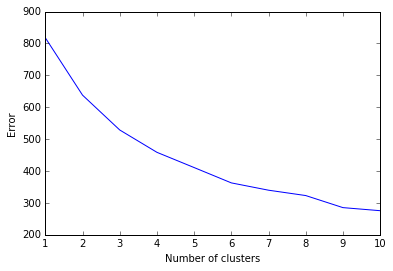

In [49]:
import json
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as hr
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

restaurant = []
file_name="yelp_academic_dataset_business.json"
count = 0
cat = []
att = []
with open(file_name) as f:
    for line in f:
        js = json.loads(line)
        city = js['city']
        b_type = str(js['categories'])
        attr = js['attributes']
        attr_list = []
        
        if ('Take-out' in attr and attr['Take-out'] == True):
            attr_list.append("Take-out")
        if ('Outdoor Seating' in attr and attr['Outdoor Seating'] == True):
            attr_list.append("Outdoor Seating")
        if ('Takes Reservations' in attr and attr['Takes Reservations']) == True:
            attr_list.append("Takes Reservations")
        if ('Accepts Credit Cards' in attr and attr['Accepts Credit Cards'] == True):
            attr_list.append("Accepts Credit Cards")
        """
        if ('Delivery' in attr and attr['Delivery'] == True):
            attr_list.append("Delivery")
        """
        if ('Waiter Service' in attr and attr['Waiter Service'] == True):
            attr_list.append("Waiter Service")
        if(city == "Las Vegas" and "Restaurant" in b_type and "Italian" in b_type):
            #print b_type
            #print attr_list
            count = count + 1
            bId =  js['business_id']
            #tmp = [float(js['latitude']),float(js['longitude']), float(js['stars'])]
            tmp = [float(js['longitude']), float(js['latitude'])]
            cat.append(b_type)
            restaurant.append(tmp)
            att.append(str(attr_list))

vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(cat).toarray() 
P = vectorizer.fit_transform(att).toarray() 
Y = np.array(restaurant)
Q = np.concatenate((P,X),axis=1)
Z = np.concatenate((Y,Q),axis=1)

error = np.zeros(11)
error[0] = 0;
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(Z)
    error[k] = kmeans.inertia_

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

The above plot shows that as long as we choose K bigger than 10, the error should not be very big.

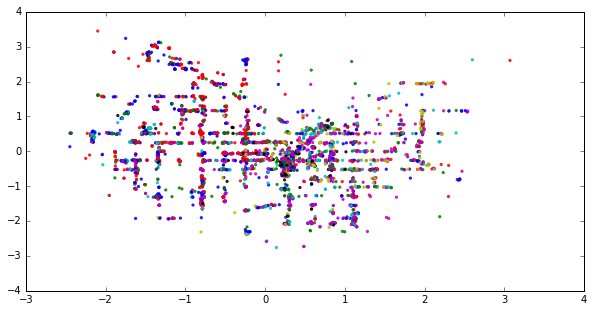

In [12]:
import json
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as hr
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

restaurant = []
file_name="yelp_academic_dataset_business.json"
count = 0
cat = []
att = []
with open(file_name) as f:
    for line in f:
        js = json.loads(line)
        city = js['city']
        b_type = str(js['categories'])
        attr = js['attributes']
        attr_list = []
        
        if ('Take-out' in attr and attr['Take-out'] == True):
            attr_list.append("Take-out")
        if ('Outdoor Seating' in attr and attr['Outdoor Seating'] == True):
            attr_list.append("Outdoor Seating")
        if ('Takes Reservations' in attr and attr['Takes Reservations']) == True:
            attr_list.append("Takes Reservations")
        if ('Accepts Credit Cards' in attr and attr['Accepts Credit Cards'] == True):
            attr_list.append("Accepts Credit Cards")
        
        if ('Delivery' in attr and attr['Delivery'] == True):
            attr_list.append("Delivery")
        
        if ('Waiter Service' in attr and attr['Waiter Service'] == True):
            attr_list.append("Waiter Service")
        if(city == "Las Vegas" and "Restaurant" in b_type):
            #print b_type
            #print attr_list
            count = count + 1
            bId =  js['business_id']
            tmp = [float(js['longitude']), float(js['latitude'])]
            cat.append(b_type)
            restaurant.append(tmp)
            att.append(str(attr_list))

vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(cat).toarray() 
P = vectorizer.fit_transform(att).toarray() 
Y = np.array(restaurant)
Q = np.concatenate((P,X),axis=1)

pca = PCA(n_components=5)
pca_Q = pca.fit_transform(Q)

Z = np.concatenate((Y,pca_Q),axis=1)

H = StandardScaler().fit_transform(Z)
ward = cluster.AgglomerativeClustering(n_clusters=12,linkage='ward')
ward.fit(H)
y_pred = ward.labels_
plt.figure(figsize=(10,5))
plt.scatter(H[:, 0], H[:, 1], color=colors[y_pred].tolist(), s=5, alpha=0.8)


(4657, 4) (4658, 218)


/Users/yili/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


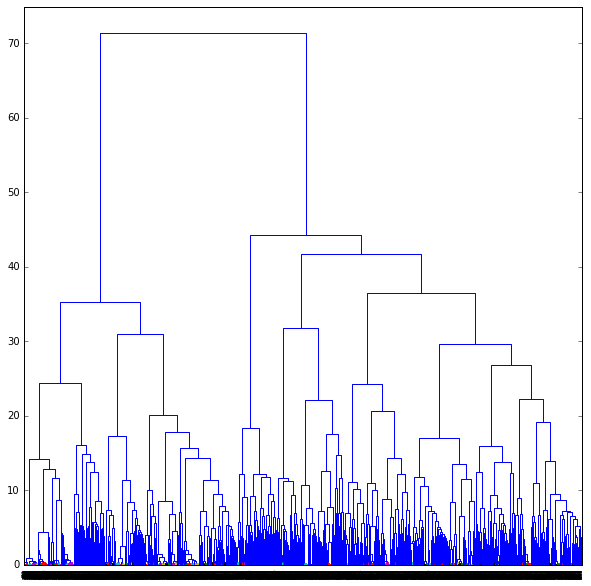

In [1]:
import json
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as hr
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def hierarchical_method(X):
    Z = linkage(X, method='ward',metric='euclidean')
    print Z.shape, X.shape
    fig = plt.figure(figsize=(10,10))
    T = hr.dendrogram(Z,color_threshold=0.4, leaf_font_size=4)
    fig.show()
    return


colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

restaurant = []
file_name="yelp_academic_dataset_business.json"
count = 0
cat = []
att = []
with open(file_name) as f:
    for line in f:
        js = json.loads(line)
        city = js['city']
        b_type = str(js['categories'])
        attr = js['attributes']
        attr_list = []
        
        if ('Take-out' in attr and attr['Take-out'] == True):
            attr_list.append("Take-out")
        if ('Outdoor Seating' in attr and attr['Outdoor Seating'] == True):
            attr_list.append("Outdoor Seating")
        if ('Takes Reservations' in attr and attr['Takes Reservations']) == True:
            attr_list.append("Takes Reservations")
        if ('Accepts Credit Cards' in attr and attr['Accepts Credit Cards'] == True):
            attr_list.append("Accepts Credit Cards")
        if ('Delivery' in attr and attr['Delivery'] == True):
            attr_list.append("Delivery")
        if ('Waiter Service' in attr and attr['Waiter Service'] == True):
            attr_list.append("Waiter Service")
        if(city == "Las Vegas" and "Restaurant" in b_type):
            #print b_type
            #print attr_list
            count = count + 1
            bId =  js['business_id']
            tmp = [float(js['longitude']), float(js['latitude'])]
            cat.append(b_type)
            restaurant.append(tmp)
            att.append(str(attr_list))

vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(cat).toarray() 
P = vectorizer.fit_transform(att).toarray() 
Y = np.array(restaurant)
Q = np.concatenate((P,X),axis=1)
Z = np.concatenate((Y,Q),axis=1)
#print Q
hierarchical_method(Z)




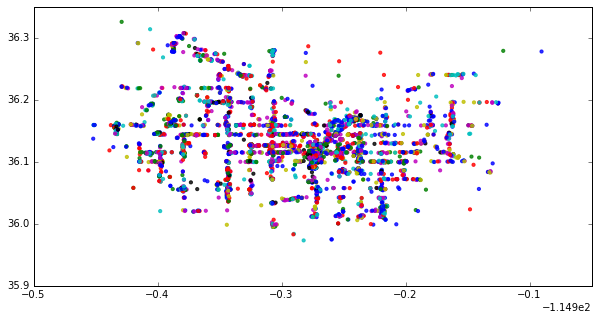

In [13]:
import json
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as hr
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import mixture
import numpy as np

def hierarchical_method(X):
    Z = linkage(X, method='ward',metric='euclidean')
    print Z.shape, X.shape
    fig = plt.figure(figsize=(5,5))
    T = hr.dendrogram(Z,color_threshold=0.4, leaf_font_size=4)
    fig.show()
    return


colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

restaurant = []
file_name="yelp_academic_dataset_business.json"
count = 0
cat = []
att = []
with open(file_name) as f:
    for line in f:
        js = json.loads(line)
        city = js['city']
        b_type = str(js['categories'])
        attr = js['attributes']
        attr_list = []
        
        if ('Take-out' in attr and attr['Take-out'] == True):
            attr_list.append("Take-out")
        if ('Outdoor Seating' in attr and attr['Outdoor Seating'] == True):
            attr_list.append("Outdoor Seating")
        if ('Takes Reservations' in attr and attr['Takes Reservations']) == True:
            attr_list.append("Takes Reservations")
        if ('Accepts Credit Cards' in attr and attr['Accepts Credit Cards'] == True):
            attr_list.append("Accepts Credit Cards")
        if ('Delivery' in attr and attr['Delivery'] == True):
            attr_list.append("Delivery")
        if ('Waiter Service' in attr and attr['Waiter Service'] == True):
            attr_list.append("Waiter Service")
        if(city == "Las Vegas" and "Restaurant" in b_type):
            #print b_type
            #print attr_list
            count = count + 1
            bId =  js['business_id']
            tmp = [float(js['longitude']), float(js['latitude'])]
            cat.append(b_type)
            restaurant.append(tmp)
            att.append(str(attr_list))

vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(cat).toarray() 
P = vectorizer.fit_transform(att).toarray() 
Y = np.array(restaurant)
Q = np.concatenate((P,X),axis=1)

pca = PCA(n_components=5)
pca_Q = pca.fit_transform(Q)

Z = np.concatenate((Y,pca_Q),axis=1)
#hierarchical_method(Z)
gmm = mixture.GMM(n_components=20, covariance_type='diag')
gmm.fit(Z)
y_pred = gmm.predict(Z)
plt.figure(figsize=(10,5))
plt.scatter(Z[:, 0], Z[:, 1], color=colors[y_pred].tolist(), s=10, alpha=0.8)

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

In [2]:
import json
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as hr
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

restaurant = []
file_name="yelp_academic_dataset_business.json"
count = 0
cat = []
att = []
with open(file_name) as f:
    for line in f:
        js = json.loads(line)
        city = js['city']
        b_type = str(js['categories'])
        attr = js['attributes']
        attr_list = []
        
        if ('Take-out' in attr and attr['Take-out'] == True):
            attr_list.append("Take-out")
        if ('Outdoor Seating' in attr and attr['Outdoor Seating'] == True):
            attr_list.append("Outdoor Seating")
        if ('Takes Reservations' in attr and attr['Takes Reservations']) == True:
            attr_list.append("Takes Reservations")
        if ('Accepts Credit Cards' in attr and attr['Accepts Credit Cards'] == True):
            attr_list.append("Accepts Credit Cards")
        """
        if ('Delivery' in attr and attr['Delivery'] == True):
            attr_list.append("Delivery")
        """
        if ('Waiter Service' in attr and attr['Waiter Service'] == True):
            attr_list.append("Waiter Service")
        if(city == "Las Vegas" and "Restaurant" in b_type):
            #print b_type
            #print attr_list
            count = count + 1
            bId =  js['business_id']
            #tmp = [float(js['latitude']),float(js['longitude']), float(js['stars'])]
            tmp = [float(js['longitude']), float(js['latitude'])]
            cat.append(b_type)
            restaurant.append(tmp)
            att.append(str(attr_list))

vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(cat).toarray() 
tmp1 = vectorizer.get_feature_names()
P = vectorizer.fit_transform(att).toarray() 
tmp2 = vectorizer.get_feature_names()
Y = np.array(restaurant)
Q = np.concatenate((P,X),axis=1)
Z = np.concatenate((Y,Q),axis=1)
bigTmp = tmp1 + tmp2

k=10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit_predict(Z)
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::1]

for i in range(k):
    print "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        print ' %s' % bigTmp[ind]
        #print ind
    print

Top terms per cluster:
Cluster 0:
 active
 american
 automotive
 waiter
 teppanyaki
 festivals
 latin
 yourself
 soul
 buffets

Cluster 1:
 active
 american
 automotive
 latin
 cafes
 tea
 fusion
 diners
 fruits
 jazz

Cluster 2:
 active
 mex
 festivals
 malaysian
 yourself
 russian
 stores
 latin
 trucks
 diners

Cluster 3:
 active
 lounges
 teppanyaki
 chips
 mex
 fish
 shaved
 french
 gas
 peruvian

Cluster 4:
 active
 arts
 arcades
 teppanyaki
 yourself
 fusion
 ethnic
 delis
 vegan
 sports

Cluster 5:
 active
 yourself
 reservations
 trucks
 indian
 sushi
 karaoke
 bubble
 yogurt
 vegetarian

Cluster 6:
 active
 arcades
 arts
 teppanyaki
 yourself
 tapas
 veggies
 fusion
 hot
 ethnic

Cluster 7:
 active
 bakeries
 asian
 gastropubs
 spaces
 mex
 coffee
 traditional
 ukrainian
 performing

Cluster 8:
 active
 teppanyaki
 take
 fish
 russian
 stores
 live
 soup
 pot
 karaoke

Cluster 9:
 active
 teppanyaki
 yourself
 gas
 specialty
 tapas
 rooms
 live
 fusion
 hot



All the features listed above are farthurest to the centroids. And they are the outliers.

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

For the K means ++, it shows a lot of restaurant are in the same color(cluster) at very beginning. Probably it's because I retrieved the categories from the dataset and it has so many categories. Every category has become less important becuase of the large size of the categories. After using dimensionality reduction, it matches what I was imaging. For the GMM clustering, it is just like what I imagined. For a city like Las Vegas, if we visualize the data points geographically, the genres of restaurants must be very diverse. Each hotel should have different many types of restaurants. Especially in downtown Las Vegas, there are varieties of restaurants over there.

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()